# Garbage Classification using CNN (Undergraduate Project)

This notebook implements a lightweight Convolutional Neural Network (CNN) for classifying garbage into **plastic**, **organic**, and **metal** categories.
It follows the coursework requirements for Part A of the Computer Vision module.


In [5]:
# ============================
# 0) Imports and Configuration
# ============================
import os, random, shutil, glob, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset paths
RAW_DIR = "dataset_full"   # Your full dataset (one folder per class)
BASE_DIR = "dataset"       # Output with train/val/test split

# Split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
DO_SPLIT = True   # Set True first time to auto-split, then False later

# Classes (folders inside dataset_full)
CLASSES = ["plastic", "organic", "metal"]

# Training config
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 12
NUM_CLASSES = len(CLASSES)



In [8]:
# ==================================
# 1) Auto-Split Dataset (Run Once)
# ==================================
def safe_mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

if DO_SPLIT:
    # Create train/val/test directories
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            safe_mkdir(os.path.join(BASE_DIR, split, cls))

    for cls in CLASSES:
        src = os.path.join(RAW_DIR, cls)
        images = glob.glob(os.path.join(src, "*"))
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val   = int(n_total * val_ratio)

        train_files = images[:n_train]
        val_files   = images[n_train:n_train+n_val]
        test_files  = images[n_train+n_val:]

        for f in train_files:
            shutil.copy(f, os.path.join(BASE_DIR, "train", cls))
        for f in val_files:
            shutil.copy(f, os.path.join(BASE_DIR, "val", cls))
        for f in test_files:
            shutil.copy(f, os.path.join(BASE_DIR, "test", cls))

        print(f"{cls}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

    print("✅ Dataset split complete!")

# Paths after splitting
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

plastic: 0 train, 0 val, 0 test
organic: 0 train, 0 val, 0 test
metal: 0 train, 0 val, 0 test
✅ Dataset split complete!


In [6]:
# ==================================
# 2) Data Generators (Preprocessing)
# ==================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_data = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_data.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

Found 210 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 31 images belonging to 3 classes.
Class indices: {'metal': 0, 'organic': 1, 'plastic': 2}


In [9]:
# ==================================
# 3) Build Lightweight CNN
# ==================================
def build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = build_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/Users/yasiruchamuditha/Me/work/vision/PythonDataScience2/ObjectDetection1/objectdetection/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,659 (8.36 MB)

 Trainable params: 2,190,659 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ==================================
# 4) Training with Callbacks
# ==================================
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/Users/yasiruchamuditha/Me/work/vision/PythonDataScience2/ObjectDetection1/objectdetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3239 - loss: 1.1652 - val_accuracy: 0.3333 - val_loss: 1.0826 - learning_rate: 0.0010
Epoch 2/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4406 - loss: 1.0660 - val_accuracy: 0.5167 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 3/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6004 - loss: 0.9254 - val_accuracy: 0.5833 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 4/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.6188 - loss: 0.7996 - val_accuracy: 0.6833 - val_loss: 0.7753 - learning_rate: 0.0010
Epoch 5/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.6212 - loss: 0.7649 - val_accuracy: 0.5833 - val_loss: 0.7753 - learning_rate: 0.0010
Epoch 6/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.6462 - loss: 0.7523 - val_accuracy: 0.6833 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 7/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.7419 - loss: 0.7051 - val_accuracy: 

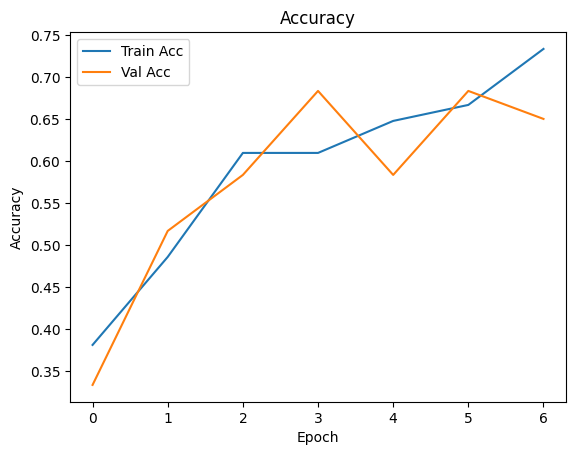

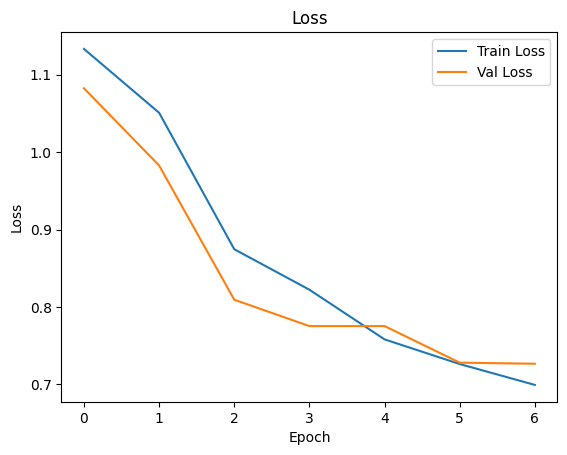

In [11]:
# ==================================
# 5) Plot Training Curves
# ==================================
def plot_curves(history):
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_curves(history)


In [12]:
# 7) Save model
model.save("garbage_classifier.h5")
print("Model saved as garbage_classifier.h5")


Model saved as garbage_classifier.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Classification Report:
              precision    recall  f1-score   support

       metal       0.50      0.60      0.55        10
     organic       0.89      0.80      0.84        10
     plastic       0.70      0.64      0.67        11

    accuracy                           0.68        31
   macro avg       0.70      0.68      0.68        31
weighted avg       0.70      0.68      0.68        31



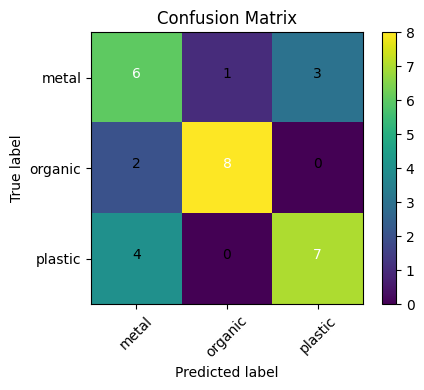

In [13]:
# ==================================
# 6) Evaluate on Test Set
# ==================================
test_steps = test_data.samples // test_data.batch_size + int(test_data.samples % test_data.batch_size != 0)
probs = model.predict(test_data, steps=test_steps, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = test_data.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(NUM_CLASSES)]))

cm = confusion_matrix(y_true, y_pred)
classes = [idx_to_class[i] for i in range(NUM_CLASSES)]

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes)


In [14]:
# ==================================
# 7) Save Model
# ==================================
model.save("garbage_classifier.h5")
print("✅ Model saved as garbage_classifier.h5")

✅ Model saved as garbage_classifier.h5
